# Soal 1 - Data Transformation Case

## Objectives
* Identify top products based on the total transaction revenue per day.
* Detect any anomalies, such as a sharp decrease or increase in the number of transactions for a specific product.
* Identify the most profitable city or province based on the total transaction revenue.

## Import all neccessary libraries

In [1]:
import polars as pl 
import seaborn as sns
import matplotlib.pyplot as plt


## Data Collection

After identifying the objectives, the columns which contribute are `date`,`v2ProductName`,`totalTransactionRevenue`. So I read those columns from dataset

In [14]:
# Read the CSV file
df = pl.read_csv("ecommerce-session-bigquery.csv",
                columns = [ 'date',
                            'v2ProductName',
                            'totalTransactionRevenue',
                            'city',
                            'country'
                        ]
                )

## Exploratory Data Analysis (EDA)

In [15]:
# Cast date column to date type
df = df.with_columns(pl.col('date').cast(pl.Utf8).str.to_date('%Y%m%d'))

### Identify top products based on the total transaction revenue per day

I made prompt to immediately answer all objectives like this
![image.png](media/Pasted%20image.png)


but the answer lead to errors which not available in the official documentation. So decided to handle line by line.

![image.png](media/Pasted%20image%201.png)

In [4]:
# The code to answer the objective 1
top_product_per_transaction_daily = df.groupby(['date', 'v2ProductName'],
                                                maintain_order=True)\
                                        .agg(pl.col('totalTransactionRevenue').sum())\
                                        .sort('totalTransactionRevenue',
                                               descending=True)
                                               
# Show top 10 of the top product based on daily total transaction
top_product_per_transaction_daily.head()

date,v2ProductName,totalTransactionRevenue
date,str,i64
2017-04-07,"""YouTube RFID J…",6831960000
2016-08-25,"""Sport Bag""",6239580000
2016-08-22,"""Collapsible Sh…",5982170000
2016-08-22,"""Google Tote Ba…",5945580000
2016-08-25,"""Google Tote Ba…",4087500000


**Insight**: 

The table showed that `YouTube RFID Journal` is the first rank of total transaction

### Detect any anomalies, such as a sharp decrease or increase in the number of transactions for a specific product.



Since the  `v2ProductName` has to many unique values, I decided to plot only top 10 of it.

In [5]:
# Select top 10 of v2ProductName
product_to_plot=top_product_per_transaction_daily['v2ProductName']\
                                                                .head(10)\
                                                                .unique()

In [16]:
# Drop null values and make sure it clean
top_product_per_transaction_daily.filter(pl.col('v2ProductName').is_in( product_to_plot))\
                                    .drop_nulls()\
                                    .null_count()

date,v2ProductName,totalTransactionRevenue
u32,u32,u32
0,0,0


In [17]:
# Assign cleaned data to variable
data_to_plot= top_product_per_transaction_daily.filter(pl.col('v2ProductName').is_in( product_to_plot))\
                                                .drop_nulls()

I decided to plot all together immediately but I got uninformative plot

<Axes: xlabel='date', ylabel='totalTransactionRevenue'>

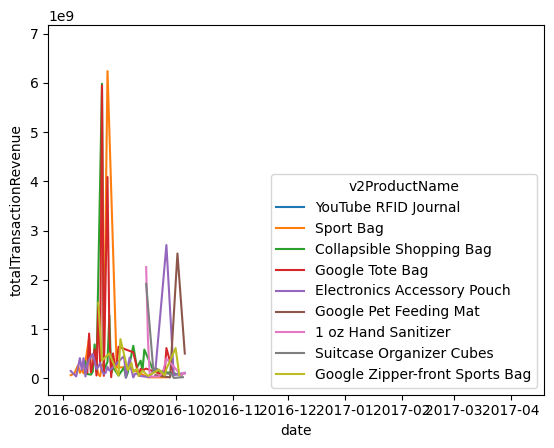

In [9]:
# Plot all together immediately
sns.lineplot(   x = 'date',
                y='totalTransactionRevenue',
                hue = 'v2ProductName',
                data = data_to_plot.to_pandas()
            )

After that I asked ChatGPT again to suggest me the best way to plot with this prompt

![prompt](media/Pasted%20image%202.png)

and I got this 

![answer](media/Pasted%20image%203.png)

since I used `polars`, I asked again with this prompt

![prompt](media/Pasted%20image%204.png)

as the result,

![answer](media/Pasted%20image%205.png)

Just like what I want but, I modified pivot table slightly in `in_col` because it is invalid syntax and `agg` because I did not need it also invalid syntax. With different syntax in pivot table, it need to modify plot syntax.


In [10]:
# Create pivot table
pivot_data = data_to_plot.pivot(    index='date',
                                    columns='v2ProductName', 
                                    values='totalTransactionRevenue'
                                )

/tmp/ipykernel_78958/3334918893.py:1: DeprecationWarning: In a future version of polars, the default `aggregate_function` will change from `'first'` to `None`. Please pass `'first'` to keep the current behaviour, or `None` to accept the new one.
  pivot_data = data_to_plot.pivot(index='date',columns='v2ProductName', values='totalTransactionRevenue')


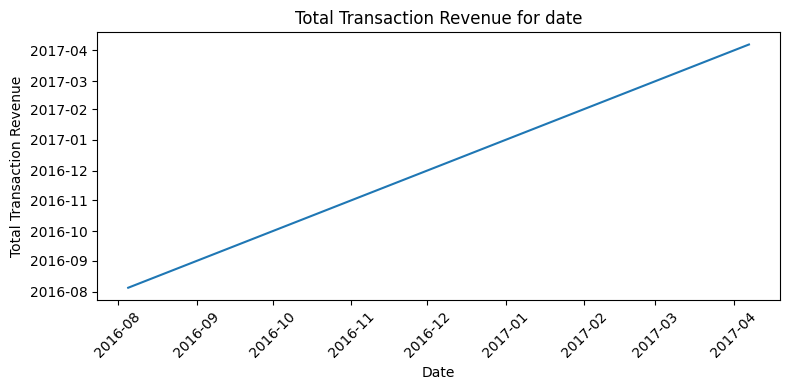

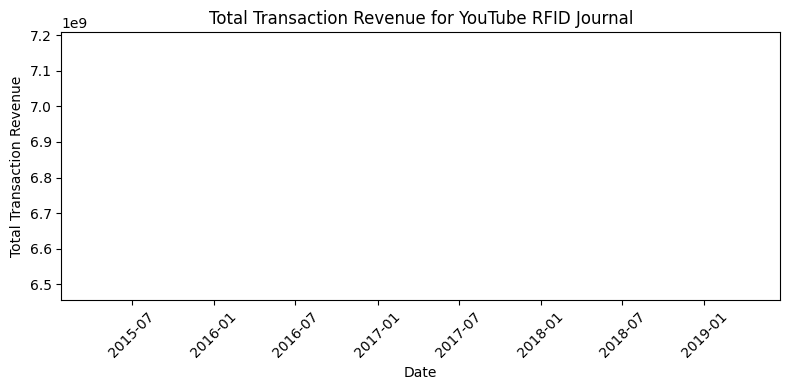

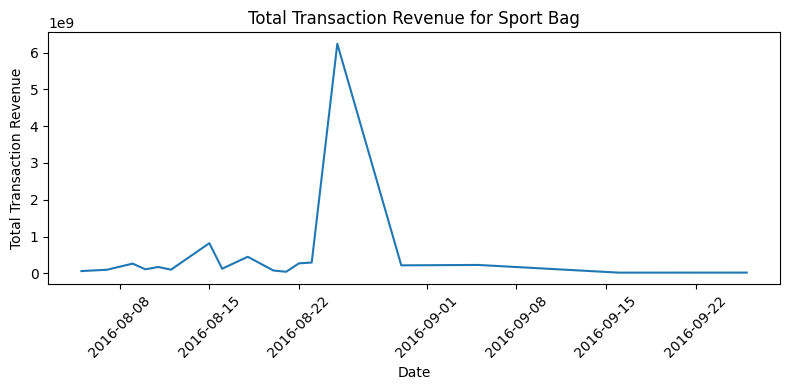

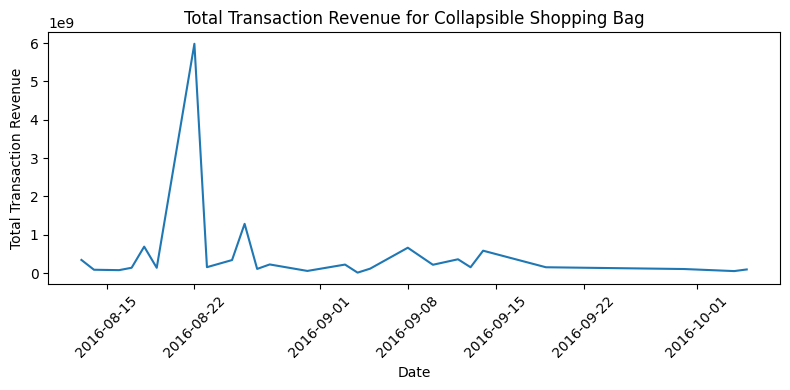

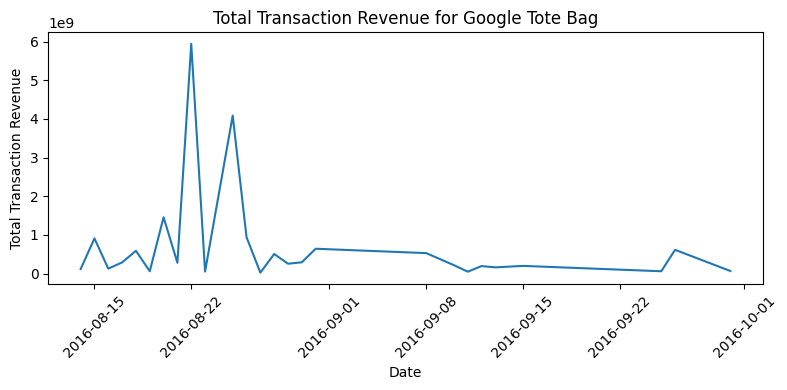

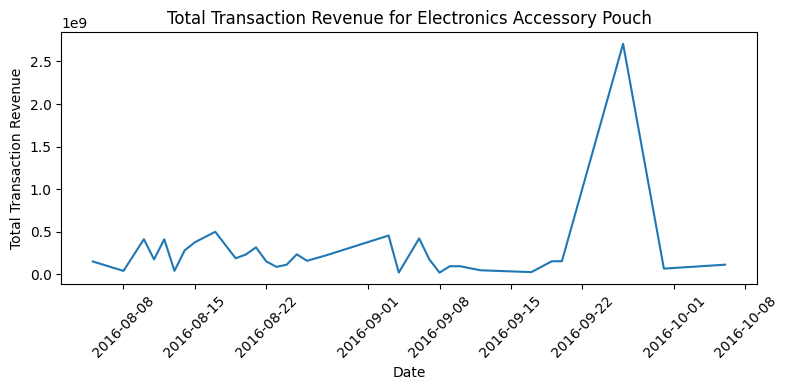

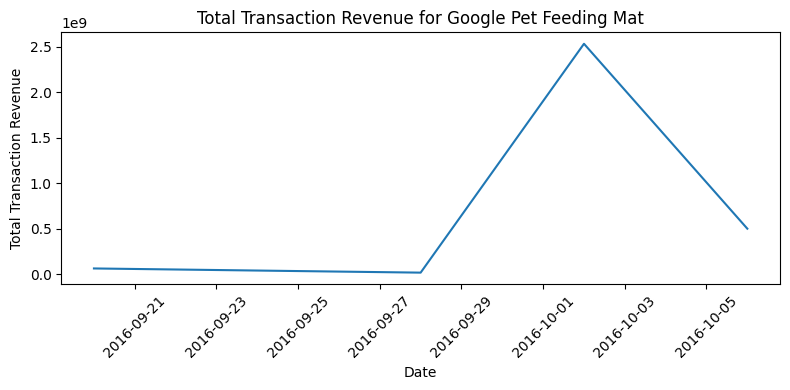

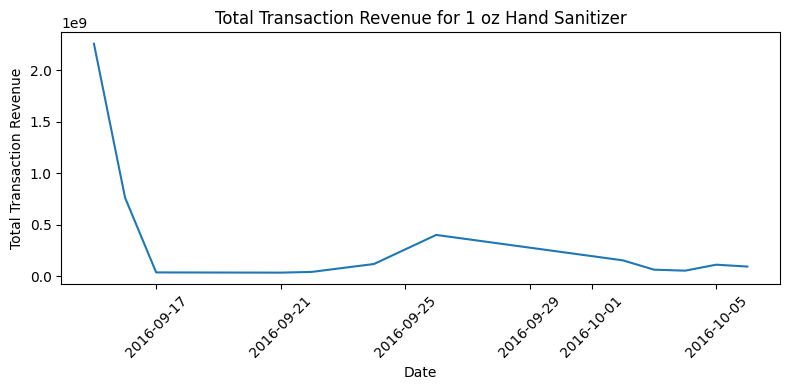

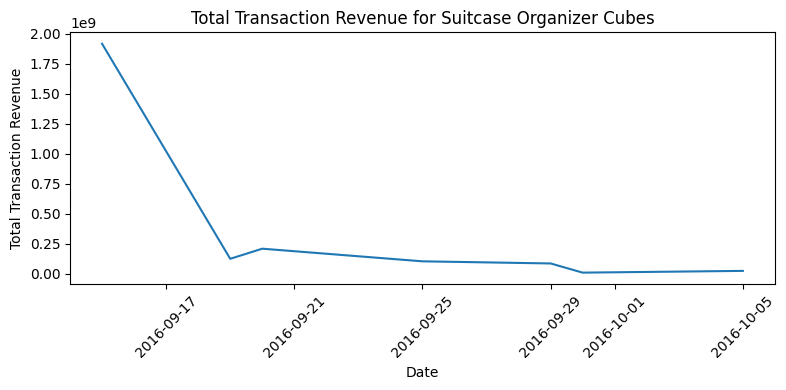

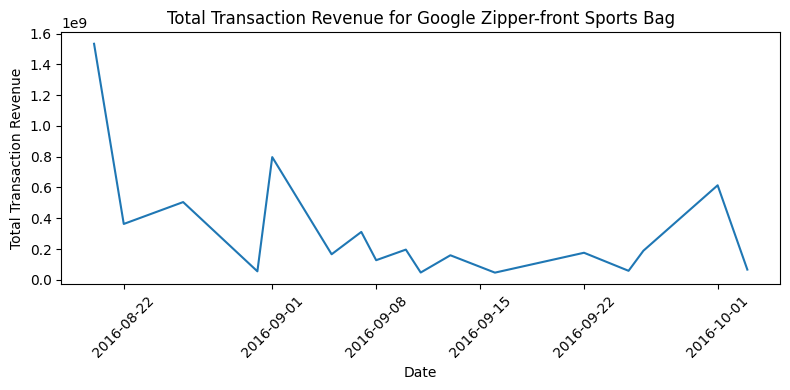

In [11]:
# Plot each columns to lineplot
for col in pivot_data.columns:
    plt.figure(figsize=(8, 4))
    sns.lineplot(data=pivot_data.to_pandas(), x='date', y=col)
    plt.title(f'Total Transaction Revenue for {col}')
    plt.xlabel('Date')
    plt.ylabel('Total Transaction Revenue')
    plt.xticks(rotation=45)
    plt.tight_layout()


**Insight**:

The showed there is anomaly in several columns:
- Sport Bag increased sharply between `2016-8-22` and `2016-9-1`
- Collapsible Shopping Bag increased sharply in `2016-8-22`
- Google Tote Bag increased sharply twice in `2016-08-22` and `2016-08-25`
- Electronics Accessory Pouch increased sharply in `2016-08-23` 

### Identify the most profitable city or province based on the total transaction revenue.

After exploring the data columns, I found that there is `city` but there is not `province` but `country`. 
So, I decided to use `city`, `totalTransactionRevenue` and `country` to complete the objective

In [12]:
# The code to answer the objective 3
top_transaction_per_city_country = df.groupby(['city','country'])\
                                        .agg(pl.col('totalTransactionRevenue').sum())\
                                        .sort('totalTransactionRevenue',descending=True)

In [13]:
# Show top 5 total transaction based on city and country
top_transaction_per_city_country.head()

city,country,totalTransactionRevenue
str,str,i64
"""not available …","""United States""",54184670000
"""New York""","""United States""",21250810000
"""San Francisco""","""United States""",7774340000
"""not available …","""Venezuela""",7191120000
"""Mountain View""","""United States""",5713290000


**Insight**:

The table show that the first rank of total transaction is country `United States`